In [1]:
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
import cvxpy as cp
import scipy

rng = np.random.default_rng()

In [3]:
t_i = rng.uniform(0, 1, 500)
t_i.sort()

In [4]:
def rbf(x, center, epsilon):
    return np.exp(-((epsilon * (x - center)) ** 2))

In [5]:
rbfs = [partial(rbf, center=i, epsilon=50) for i in [0.2, 0.4, 0.6, 0.8]]


true_y = 6 * np.sum([(t_i - 0.5) ** k for k in [1, 2, 3]], axis=0) + 2.5 * np.sum(
    [(-1) ** j * rbfs[j - 1](t_i) for j in [1, 2, 3, 4]], axis=0
)
obs_y = true_y + rng.normal(0, 0.25**2, len(t_i))

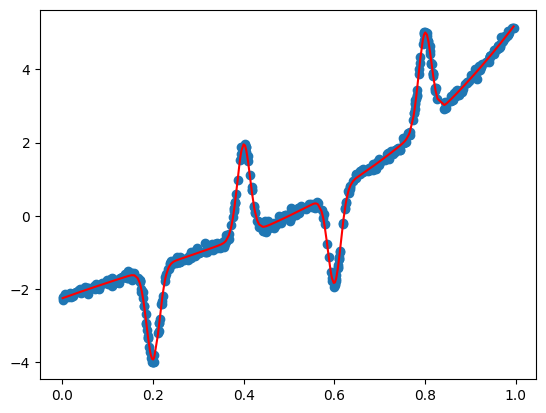

In [6]:
plt.scatter(t_i, obs_y)
plt.plot(t_i, true_y, color="r")

In [885]:
x_i = [0.167 * (n + 1) for n in range(5)]
xs = np.linspace(0, 1, 100)

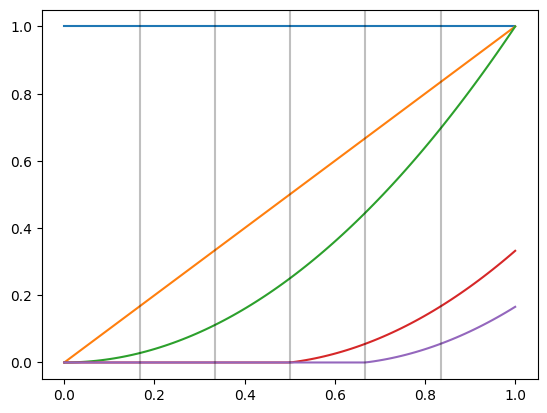

In [886]:
plt.plot(xs, np.ones_like(xs))
plt.plot(xs, [x for x in xs])
plt.plot(xs, [x**2 for x in xs])
plt.plot(xs, [(x - x_i[1]) * (x - x_i[2]) * int(x >= x_i[2]) for x in xs])
plt.plot(xs, [(x - x_i[2]) * (x - x_i[3]) * int(x >= x_i[3]) for x in xs])
for x in x_i:
    plt.axvline(x, alpha=0.25, color="black")

$$
j = 1, 2, \ldots, n \\
h_j(x) = x^{j-1} \quad \text{when} \quad j \leq k+1 \\
h_j(x) = \prod_{\ell=1}^k (x - x_{j-k-1+\ell}) * \mathbb{1}(x \ge x_{j-1}) \quad \text{when} \quad j \ge k+2
$$

$$
i = j - 1 = 0, 1, \ldots, n-1 \\
h_i(x) = x^i \quad \text{when} \quad i \le k \\
h_i(x) = \prod_{\ell=1}^k (x - x_{i-k+\ell}) * \mathbb{1}(x \ge x_{i}) = \prod_{\ell=0}^{k-1} (x - x_{i-k+\ell+1}) * \mathbb{1}(x \ge x_{i})\quad \text{when} \quad i \ge k+1
$$
But, given python is zero-indexed, we have to account for this because are notation is assuming one-indexing. So, we have:
$$
h_i(x) = \prod_{\ell=0}^{k-1} (x - x_{i-k+\ell}) * \mathbb{1}(x \ge x_{i-1})\quad \text{when} \quad i \ge k+1
$$

In [887]:
def tf_basis(x, k, x_i):
    results = []
    n = len(x_i)
    for i in range(n):
        if i <= k:
            h = x**i
            results.append(h)
        elif i >= k + 1:
            h = 1
            for ell in range(k):
                h *= x - x_i[i - k + ell]
            h *= int(x >= x_i[i - 1])
            results.append(h)
    return results

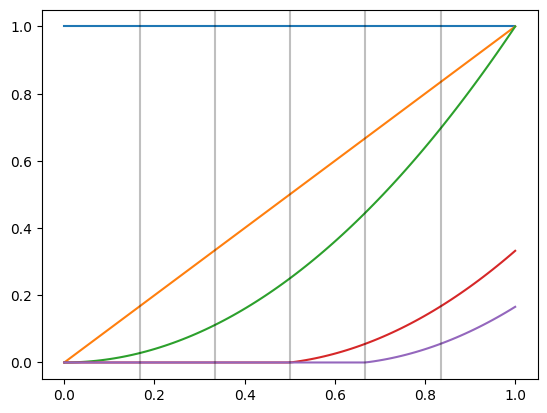

In [888]:
test = np.array([tf_basis(x, 2, x_i) for x in xs])

for n in range(test.shape[1]):
    plt.plot(xs, test[:, n])

for x in x_i:
    plt.axvline(x, alpha=0.25, color="black")

# Basis Function Approach

In [902]:
k = 0
basis_eval = np.array([tf_basis(t, k, t_i) for t in t_i])
beta = cp.Variable(len(t_i))

objective = cp.Minimize(
    0.5 * cp.sum_squares(obs_y - basis_eval @ beta) + 1 * cp.norm(beta[k + 1 :], 1)
)
prob = cp.Problem(objective)
results = prob.solve(solver="CLARABEL", verbose=True)

                                     CVXPY                                     
                                     v1.5.1                                    
(CVXPY) Jun 09 02:45:06 PM: Your problem has 500 variables, 0 constraints, and 0 parameters.
(CVXPY) Jun 09 02:45:06 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jun 09 02:45:06 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jun 09 02:45:06 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jun 09 02:45:06 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jun 09 02:45:06 PM: Compiling problem (target solver=CLARABEL).

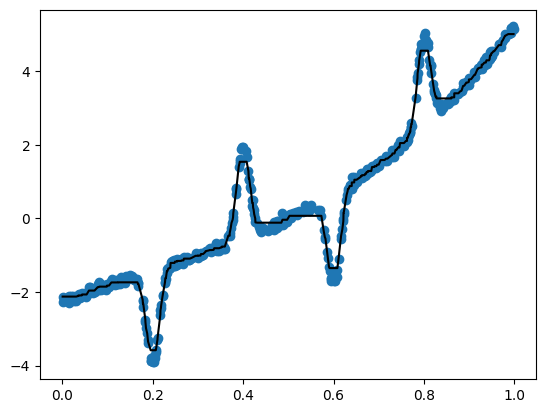

In [903]:
# High regularization results in the model only capturing the global trend. alpha = 0.01
# See coefficients to observe sparsity
predict = basis_eval @ beta.value.round(6)
plt.plot(t_i, predict, color="black")
plt.scatter(t_i, obs_y)

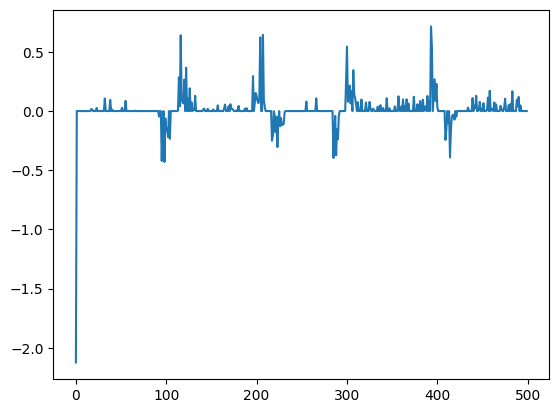

In [904]:
plt.plot(beta.value)

# Difference Operator Approach

In [931]:
k = 0
n = len(t_i)

ones = np.ones(n)
if k == 0:
    D = scipy.sparse.spdiags(np.vstack([-ones, ones]), range(2), m=n - k - 1, n=n)
elif k == 1:
    D = scipy.sparse.spdiags(
        np.vstack([ones, -2 * ones, ones]), range(3), m=n - k - 1, n=n
    )
elif k == 2:
    D = scipy.sparse.spdiags(
        np.vstack([-ones, 3 * ones, -3 * ones, ones]), range(4), m=n - k - 1, n=n
    )

In [932]:
beta = cp.Variable(n)
# plambda = cp.Parameter(1, nonneg=True)

objective = cp.Minimize(
    0.5 * cp.sum_squares(obs_y - beta) + 1000 * cp.norm(D @ beta, 1)
)
prob = cp.Problem(objective)

results = prob.solve(solver="CLARABEL", verbose=True)

                                     CVXPY                                     
                                     v1.5.1                                    
(CVXPY) Jun 09 03:14:02 PM: Your problem has 500 variables, 0 constraints, and 0 parameters.
(CVXPY) Jun 09 03:14:02 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jun 09 03:14:02 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jun 09 03:14:02 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jun 09 03:14:02 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jun 09 03:14:02 PM: Compiling problem (target solver=CLARABEL).

In [942]:
np.linalg.norm(D @ beta.value, ord=1)

3.185545538464396e-08

In [951]:
beta = cp.Variable(n)
lam = cp.Parameter(nonneg=True)

objective = cp.Minimize(0.5 * cp.sum_squares(obs_y - beta) + lam * cp.norm(D @ beta, 1))
prob = cp.Problem(objective)

results = []
for lam_value in np.logspace(-4, 6, 100):
    lam.value = lam_value
    prob.solve(solver="CLARABEL")
    results.append(np.sum((D @ beta.value).round(10)))

In [957]:
results

[7.407740505100001,
 7.407688134700001,
 7.4076220484,
 7.407538660600002,
 7.4074334426999995,
 7.407300704500001,
 7.407133557999999,
 7.4069721701999995,
 7.4069009996,
 7.406816759500001,
 7.4067105466,
 7.406576536099999,
 7.406407434099999,
 7.406194054299999,
 7.405924798299999,
 7.4055850357000015,
 7.405156303299999,
 7.404615305499998,
 7.403932644800001,
 7.4030712224,
 7.4019842323,
 7.4006126057,
 7.398881808800001,
 7.396697789599999,
 7.393941864,
 7.387271760599999,
 7.376740078299999,
 7.3634506022,
 7.3484831648,
 7.3442072323000005,
 7.336578187900001,
 7.3269514274,
 7.314803831099999,
 7.299475301299999,
 7.2837821057,
 7.2658025419,
 7.2473554700000005,
 7.2240779096,
 7.1947049631,
 7.1576405055,
 7.1156604481,
 7.0661955249999995,
 7.0143427655,
 6.953499525200001,
 6.882774015400001,
 6.800527412499999,
 6.7001538488,
 6.5993354952,
 6.5209347517,
 6.4472366555,
 6.376353828499999,
 6.3005034127999995,
 6.166489110700001,
 6.0105639907,
 5.8242740737,
 5.600490

In [959]:
results == 0

False

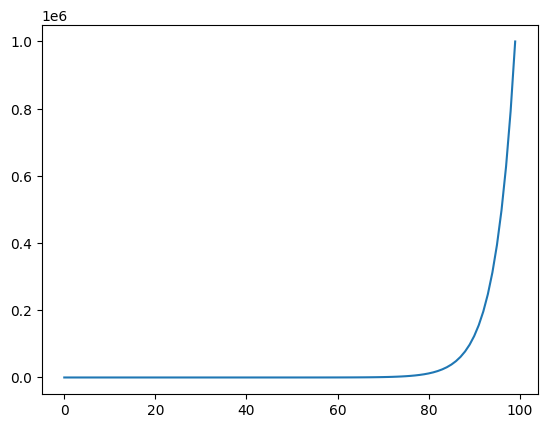

In [955]:
plt.plot(np.logspace(-4, 6, 100))

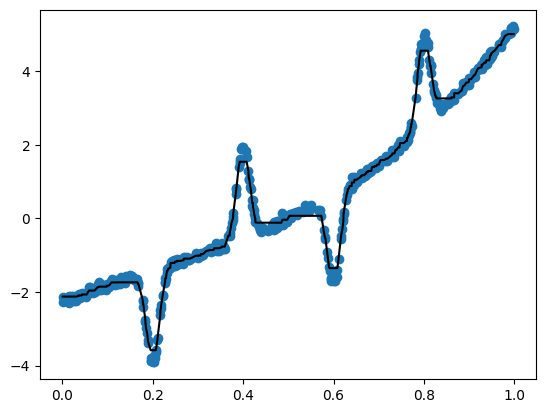

In [907]:
plt.plot(t_i, beta.value, color="black")
plt.scatter(t_i, obs_y)

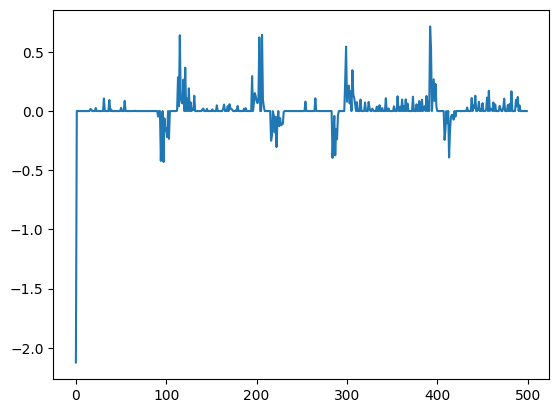

In [908]:
basis_beta = np.concatenate([beta.value[: k + 1], D @ beta.value])

plt.plot(basis_beta)

In [909]:
xs = np.linspace(-0.5, 1.5, 10000)
oos_test = np.array([tf_basis(x, k, t_i) for x in xs])

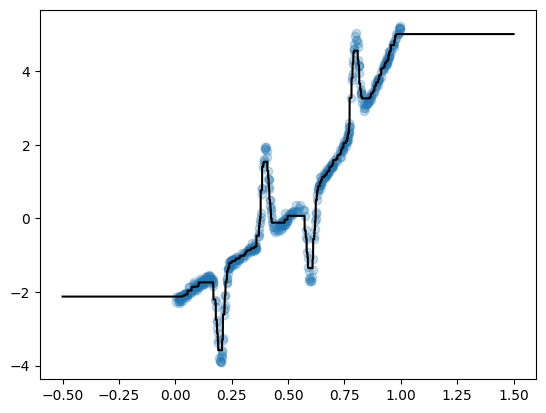

In [910]:
plt.scatter(t_i, obs_y, alpha=0.25)
plt.plot(xs, oos_test @ basis_beta, color="black")

# GLM

In [128]:
import jax.numpy as jnp
import jax
import optax

### Single Variate

In [314]:
x_i = rng.uniform(0, 100, 1000)
sort_idx = np.argsort(x_i)
true_y = np.sin(0.1 * x_i) ** 2 + 1

k = 50
theta = true_y / k
obs_y = rng.gamma(k, theta)

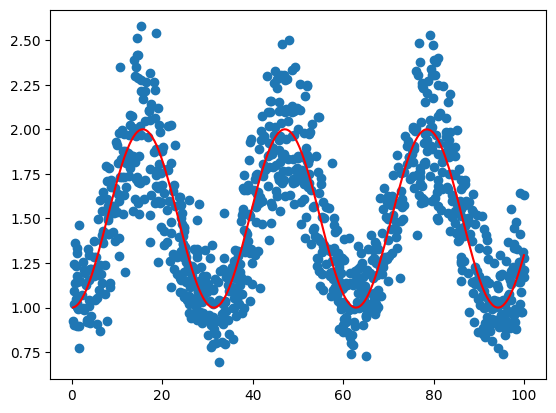

In [315]:
plt.scatter(x_i, obs_y)
plt.plot(x_i[sort_idx], true_y[sort_idx], color="r")

In [316]:
bins = 100
qs = np.linspace(1 / bins, (bins - 1) / bins, bins)
quantiles = np.quantile(x_i, qs, method="median_unbiased")
bin_nums = np.searchsorted(quantiles, x_i)

In [317]:
X = np.eye(bins + 1)[bin_nums]

In [318]:
@jax.jit
def gamma_deviance(y_hat, y):
    return 2 * (jnp.log(y_hat / y) + y / y_hat - 1)


@jax.jit
def trend_filter_penalty(beta, D):
    return jnp.linalg.norm(D @ beta, ord=1)


def gamma_trend_filter(beta, X, y, lam, D):
    mu = jnp.exp(X @ beta)
    return gamma_deviance(mu, y).sum() + lam * trend_filter_penalty(beta, D)

In [345]:
ones = np.ones(bins + 1)
D = scipy.sparse.spdiags(
    np.vstack([-ones, ones]), range(2), m=bins, n=bins + 1
).toarray()
D = jnp.asarray(D)
beta = jnp.asarray(rng.random(bins + 1))

In [346]:
X_jax = jnp.asarray(X)
y_jax = jnp.asarray(obs_y)
lam = 5


def obj(beta):
    return gamma_trend_filter(beta, X_jax, y_jax, lam, D)


solver = optax.lbfgs(
    linesearch=optax.scale_by_zoom_linesearch(
        max_linesearch_steps=15, approx_dec_rtol=None, tol=1e-3, increase_factor=4
    )
)
opt_state = solver.init(beta)
value_and_grad = optax.value_and_grad_from_state(obj)

old_value = obj(beta)
no_prog_steps = 0
while True:
    value, grad = value_and_grad(beta, state=opt_state)
    print(f"Objective Value: {value}")
    print(f"Gradient Norm: {jnp.linalg.norm(grad, ord=1)}")

    if jnp.abs(grad).sum() < 1e-5:
        print("Gradient Norm Stop")
        break

    updates, opt_state = solver.update(
        grad,
        opt_state,
        beta,
        value=value,
        grad=grad,
        value_fn=obj,
    )
    beta = optax.apply_updates(beta, updates)

    new_value = obj(beta)
    if jnp.abs((new_value - old_value) / old_value) < 1e-3:
        no_prog_steps += 1
    if no_prog_steps > 5:
        print("No objective progress stop")
        break
    old_value = new_value

Objective Value: 317.8957824707031
Gradient Norm: 1131.076904296875
Objective Value: 203.23158264160156
Gradient Norm: 1096.0804443359375
Objective Value: 128.52243041992188
Gradient Norm: 946.3477783203125
Objective Value: 74.89199829101562
Gradient Norm: 677.6984252929688
Objective Value: 66.75651550292969
Gradient Norm: 632.0709838867188
Objective Value: 57.4463996887207
Gradient Norm: 600.0643310546875
Objective Value: 51.35066223144531
Gradient Norm: 435.5057373046875
Objective Value: 48.967533111572266
Gradient Norm: 456.1019287109375
Objective Value: 47.578529357910156
Gradient Norm: 369.0650634765625
Objective Value: 46.71861267089844
Gradient Norm: 325.869873046875
Objective Value: 45.813358306884766
Gradient Norm: 270.1483154296875
Objective Value: 45.444725036621094
Gradient Norm: 261.2182312011719
Objective Value: 44.777732849121094
Gradient Norm: 356.0535583496094
Objective Value: 44.35054016113281
Gradient Norm: 371.4313659667969
Objective Value: 43.716068267822266
Gradie

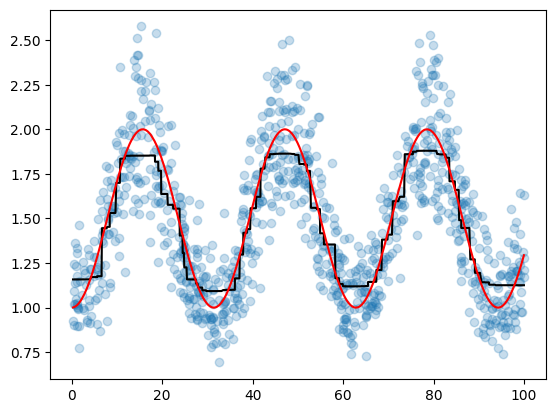

In [347]:
plt.plot(x_i[sort_idx], np.asarray(jnp.exp(X_jax @ beta))[sort_idx], color="black")
plt.plot(x_i[sort_idx], true_y[sort_idx], color="r")
plt.scatter(x_i, obs_y, alpha=0.25)

### Multi-Variate

In [634]:
x_i_1 = rng.uniform(0, 100, 10000)
x_i_2 = rng.uniform(0, 1, 10000)
sort_idx_1 = np.argsort(x_i_1)
sort_idx_2 = np.argsort(x_i_2)
true_y = np.sin(0.1 * x_i_1) + np.exp(x_i_2)

k = 500
theta = true_y / k
obs_y = rng.gamma(k, theta)

In [656]:
import scipy.interpolate

plot_x = np.linspace(x_i_1.min(), x_i_1.max(), 100)
plot_y = np.linspace(x_i_2.min(), x_i_2.max(), 100)

x_grid, y_grid = np.meshgrid(plot_x, plot_y)

Z = scipy.interpolate.griddata((x_i_1, x_i_2), true_y, (x_grid, y_grid), method="cubic")


In [659]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Surface(x=plot_x, y=plot_y, z=Z)])
fig.show()

In [686]:
import interpret
import interpret.glassbox

# Changing interactions to zero substantially changes this
model = interpret.glassbox.ExplainableBoostingRegressor(["x_1", "x_2"], ["continuous", "continuous"], objective="gamma_deviance", smoothing_rounds=600)
model.fit(np.vstack([x_i_1, x_i_2]).T, obs_y)

ExplainableBoostingRegressor(feature_names=['x_1', 'x_2'],
                             feature_types=['continuous', 'continuous'],
                             objective='gamma_deviance', smoothing_rounds=600)

In [687]:
predicted = model.predict(np.vstack([x_i_1, x_i_2]).T)

Z = scipy.interpolate.griddata((x_i_1, x_i_2), predicted, (x_grid, y_grid), method="cubic")

In [688]:
fig = go.Figure(data=[go.Surface(x=plot_x, y=plot_y, z=Z)])
fig.show()

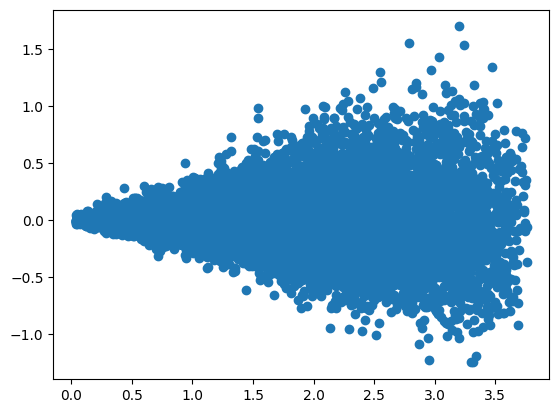

In [633]:
predicted = model.predict(np.vstack([x_i_1, x_i_2]).T)

plt.scatter(predicted, obs_y - predicted)

In [593]:
bins = 100
qs = np.linspace(1 / bins, (bins - 1) / bins, bins)

quantiles_1 = np.quantile(x_i_1, qs, method="median_unbiased")
bin_nums_1 = np.searchsorted(quantiles_1, x_i_1)

quantiles_2 = np.quantile(x_i_2, qs, method="median_unbiased")
bin_nums_2 = np.searchsorted(quantiles_2, x_i_2)

In [594]:
def get_one_hot(bins, idx):
    return np.eye(bins + 1)[idx]


X = np.hstack([get_one_hot(bins, bin_nums_1), get_one_hot(bins, bin_nums_2)])

In [608]:
def get_D_matrix(bins):
    ones = np.ones(bins + 1)
    D = scipy.sparse.spdiags(
        np.vstack([-ones, ones]), range(2), m=bins, n=bins + 1
    ).toarray()
    return D


D = get_D_matrix(bins)
D = np.block(
    [[D, np.zeros((D.shape[0], D.shape[1]))], [np.zeros((D.shape[0], D.shape[1])), D]]
)
D = jnp.asarray(D)
beta = jnp.asarray(rng.random(2 * (bins + 1) + 1))

In [609]:
@jax.jit
def gamma_deviance(y_hat, y):
    return 2 * (jnp.log(y_hat / y) + y / y_hat - 1)


@jax.jit
def trend_filter_penalty(beta, D):
    return jnp.linalg.norm(D @ beta, ord=1)


def gamma_trend_filter(beta, X, y, lam, D):
    intercept = beta[0]
    beta = beta[1:]
    mu = jnp.exp(intercept + X @ beta)
    return gamma_deviance(mu, y).sum() + lam * trend_filter_penalty(beta, D)

In [610]:
X_jax = jnp.asarray(X)
y_jax = jnp.asarray(obs_y)
lam = 0


def obj(beta):
    return gamma_trend_filter(beta, X_jax, y_jax, lam, D)


solver = optax.lbfgs(
    linesearch=optax.scale_by_zoom_linesearch(
        max_linesearch_steps=15, approx_dec_rtol=None, tol=1e-3, increase_factor=4
    )
)
opt_state = solver.init(beta)
value_and_grad = optax.value_and_grad_from_state(obj)

old_value = obj(beta)
no_prog_steps = 0
while True:
    value, grad = value_and_grad(beta, state=opt_state)
    print(f"Objective Value: {value}")

    if jnp.abs(grad).sum() < 1e-5:
        print("Gradient Norm Stop")
        break

    updates, opt_state = solver.update(
        grad,
        opt_state,
        beta,
        value=value,
        grad=grad,
        value_fn=obj,
    )
    beta = optax.apply_updates(beta, updates)

    new_value = obj(beta)
    if jnp.abs((new_value - old_value) / old_value) < 1e-3:
        no_prog_steps += 1
    if no_prog_steps > 5:
        print("No objective progress stop")
        break
    old_value = new_value

Objective Value: 11208.080078125
Objective Value: 4922.900390625
Objective Value: 4790.2646484375
Objective Value: 4549.25634765625
Objective Value: 4403.8466796875
Objective Value: 4289.47998046875
Objective Value: 4173.916015625
Objective Value: 4030.322021484375
Objective Value: 3829.55224609375
Objective Value: 3537.106201171875
Objective Value: 3117.025390625
Objective Value: 2551.197021484375
Objective Value: 1872.9775390625
Objective Value: 1101.699951171875
Objective Value: 831.5046997070312
Objective Value: 756.0828857421875
Objective Value: 728.01025390625
Objective Value: 713.8626098632812
Objective Value: 703.7139892578125
Objective Value: 693.3444213867188
Objective Value: 680.9779663085938
Objective Value: 667.7976684570312
Objective Value: 655.005859375
Objective Value: 649.4990844726562
Objective Value: 645.4562377929688
Objective Value: 643.32470703125
Objective Value: 642.3488159179688
Objective Value: 641.9208984375
Objective Value: 641.7252807617188
Objective Value:

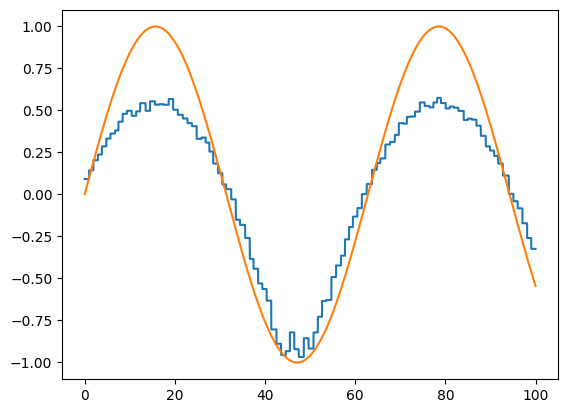

In [615]:
plt.plot(x_i_1[sort_idx_1], np.asarray(beta[0] + X[:, :101] @ beta[1:102])[sort_idx_1])
plt.plot(x_i_1[sort_idx_1], np.sin(0.1 * x_i_1)[sort_idx_1])

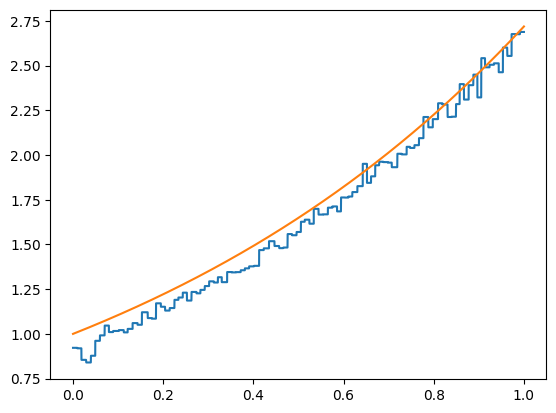

In [616]:
plt.plot(
    x_i_2[sort_idx_2],
    np.asarray(jnp.exp(X[:, 101:] @ beta[102:]))[sort_idx_2],
)
plt.plot(x_i_2[sort_idx_2], np.exp(x_i_2)[sort_idx_2])

In [600]:
pred_y = np.asarray(jnp.exp(X @ beta))
plt.scatter(obs_y, pred_y - true_y)

TypeError: dot_general requires contracting dimensions to have the same shape, got (202,) and (203,).